# Data 620 - Project 2

Baron Curtin, Heather Geiger

## Introduction

In this assignment, we are asked to choose a 2-mode network dataset to simplify and describe.

One example of a type of data that could be described as a 2-mode network is gene sets.

In human or model organism gene expression data, one will often be looking to find which genes are differentially expressed between two or more conditions.

If there is a particular single gene or short list of genes of interest, this data will be simple enough to work with.

Often though, you will have too many genes to look at to be able to just review them all manually.

So by finding what broader categories (like pathways) that these genes fit into, the data becomes much easier to interpret.

MSigDB, the Molecular Signatures Database, has organized a number of sets of genes to use for this type of analysis.

In this assignment, we will not be performing gene set enrichment analysis.

Rather, we will be exploring the reference used in this analysis (the gene set database) in greater detail.

We will use the GO (gene ontology), MF (molecular function) gene sets here. 

### Import libraries.

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import networkx.algorithms.bipartite as bipartite
import matplotlib.pyplot as plt
import math

# additional jupyter setup
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

## Dataset info

Each line in the gene set file contains information about the gene set.

The first column is the name of the gene set (e.g. "GO_CYCLIC_NUCLEOTIDE_PHOSPHODIESTERASE_ACTIVITY").

The second columns is just a web link to get more info on the gene set, and can be discarded.

Then have any number of additional fields, where each field contains the name of one gene in the gene set.

The data is available for free to download from the MSigDB website.

Unfortunately, there are no links that work with download.file or similar commands like wget/curl.

But you can paste the following link into a browser to activate download:

http://software.broadinstitute.org/gsea/msigdb/download_file.jsp?filePath=/resources/msigdb/7.0/c5.mf.v7.0.symbols.gmt

## Data loading and building the network

### Read in and format data.

Read in from ".gmt" file.

For this, we borrow code from GSEApy (https://github.com/zqfang/GSEApy/blob/master/gseapy/parser.py).

This will make it so that each gene set is a key in a dictionary.

Each value will be a list of genes.

In [2]:
with open("c5.mf.v7.0.symbols.gmt") as genesets:
    genesets_dict = {line.strip().split("\t")[0]: line.strip().split("\t")[2:]
                     for line in genesets.readlines()}    

### Build network.

Add the gene sets as nodes to a network graph.

In [3]:
G = nx.Graph()
G.add_nodes_from(list(genesets_dict.keys()), bipartite=0)

Add the genes as nodes to a network graph.

In [4]:
list_of_gene_lists = list(genesets_dict.values())
flattened_list_of_gene_lists = [item for sublist in list_of_gene_lists for item in sublist]
unique_genes = list(set(flattened_list_of_gene_lists))

G.add_nodes_from(unique_genes,bipartite=1)

Add edges between gene sets and genes by converting the dictionary to a list of tuples.

In [5]:
gene_set_sizes = [len(x) for x in list_of_gene_lists]
gene_sets_repeated = [[gene_set] * gene_set_size for gene_set_size,gene_set in zip(gene_set_sizes,list(genesets_dict.keys()))]
gene_sets_repeated = [item for sublist in gene_sets_repeated for item in sublist]

gene_set_to_gene_tuples = list(zip(flattened_list_of_gene_lists,gene_sets_repeated))

G.add_edges_from(gene_set_to_gene_tuples)

<Figure size 3600x1440 with 0 Axes>

C:\Users\bacur\Miniconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


(-1.0996568649017804,
 1.024505421420335,
 -0.9974815406079898,
 1.0698858060117376)

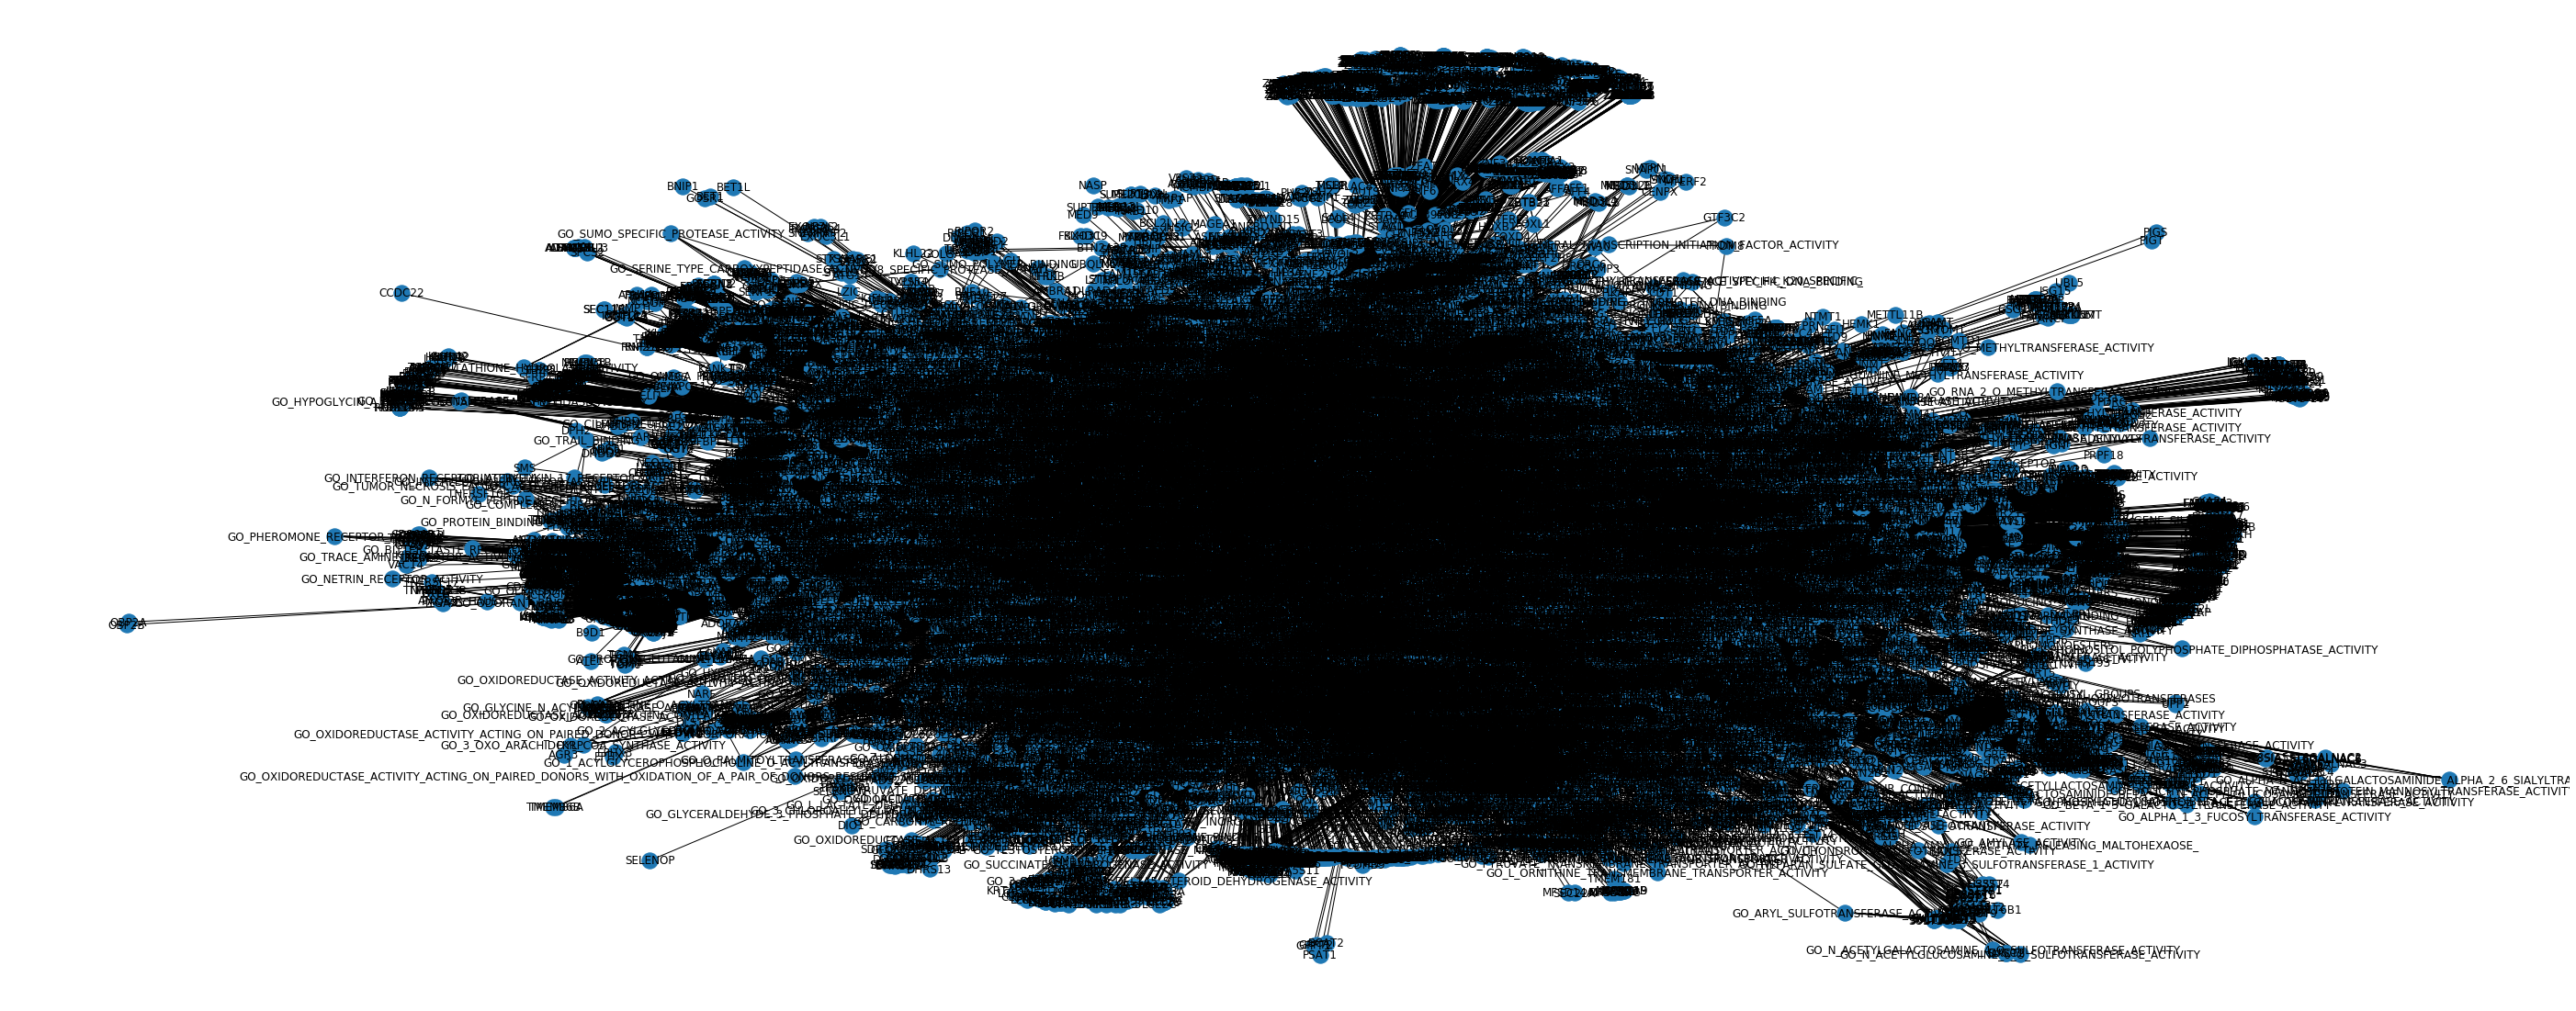

In [6]:
# draw graph
plt.figure(figsize=(50,20))
nx.draw_networkx(G)
plt.axis('off')

## Weighted projection onto gene sets

Let's do a simple weighted projection of the network onto the gene sets.

For projection onto gene sets, the weighted node degree run with ratio=False will give us the total number of times each gene in a given gene set is found in any other gene set.

The weights of each edge between two gene sets will be equal to the number of genes that they share.

The only issue with using this value to reduce the network size is that just by chance, larger gene sets are going to be more likely to share common genes with other gene sets.

So after we get these values, we will need to normalize for gene set sizes.

We will want to add the gene set sizes as an attribute to each gene set node.

In [7]:
#Project bipartite graph onto gene set nodes.
gene_sets = list(genesets_dict.keys())
projected_onto_gene_sets = bipartite.weighted_projected_graph(G, gene_sets, ratio=False)

In [8]:
#Add gene set sizes as node attributes.
for gene_set,gene_set_size in zip(gene_sets, gene_set_sizes):
    projected_onto_gene_sets.add_nodes_from([(gene_set, {'num_genes':gene_set_size})])

Use the sizes of the gene sets to normalize the weights.

Normally would want to use a Fisher exact test as described here:

https://www.reddit.com/r/bioinformatics/comments/94fkt8/gostats_hypergeometric_test_calculations/

However, this is going to take way too long to apply here.

So let's just use mean gene set size.

In [9]:
first_names_edges = [set_from for set_from,set_to in projected_onto_gene_sets.edges(data=False)]
second_names_edges = [set_to for set_from,set_to in projected_onto_gene_sets.edges(data=False)]
first_node_edges_sizes = [projected_onto_gene_sets.node[gene_set]['num_genes'] for gene_set in first_names_edges]
second_node_edges_sizes = [projected_onto_gene_sets.node[gene_set]['num_genes'] for gene_set in second_names_edges]

In [10]:
min_gene_set_size_per_node_in_edge = [min(np.asarray([x,y])) 
                                      for x,y in zip(first_node_edges_sizes, second_node_edges_sizes)]
max_gene_set_size_per_node_in_edge = [max(np.asarray([x,y])) 
                                      for x, y in zip(first_node_edges_sizes,second_node_edges_sizes)]
edge_weights = [edata['weight'] 
                for node_to, node_from, edata in projected_onto_gene_sets.edges(data=True)]

In [11]:
mean_gene_set_size_nodes_between_edges = [np.mean(np.asarray([x,y]))
                                          for x,y in zip(min_gene_set_size_per_node_in_edge, max_gene_set_size_per_node_in_edge)]
edge_weights_normalized = np.asarray(edge_weights)/mean_gene_set_size_nodes_between_edges

## Apply the Island Method

In this section, we will look to apply the island method to our gene data. First we must apply our edge weights to our graph

In [13]:
# apply edge weights to the graph
weights_dict = {(node_to, node_from): weight
                for (node_to, node_from), weight in zip(projected_onto_gene_sets.edges(), edge_weights_normalized)}

nx.set_edge_attributes(projected_onto_gene_sets, weights_dict, name='weight_norm')

### Parameter Tuning
We need to decide on an appropriate weight parameter to trim our edges. The mean or the median seem like decent candidates

In [15]:
# we just need to decide a decide parameter to trim our edges
# we can use the mean or median
# the median may be more appropriate should there be heavy skew
mean_weight = np.mean(edge_weights_normalized)
median_weight = np.median(edge_weights_normalized)

print('Mean Weight:', mean_weight)
print('Median Weight:', median_weight)

Mean Weight: 0.04289766802159297
Median Weight: 0.014705882352941176


In [17]:
# trim the edges
def trim_edges(g, weight=mean_weight):
    g2 = nx.Graph()
    for f, to, edata in g.edges(data=True):
        if edata['weight_norm'] > weight:
            g2.add_edge(f, to, weight_norm=edata['weight_norm'])
    return g2

# function to apply the island method to the graph
def island_method(g, att, iterations=5):
    weights = [edata[att] for f, to, edata in g.edges(data=True)]

    mn = min(weights)
    mx = max(weights)
    #compute the size of the step, so we get a reasonable step in iterations
    step = ((mx - mn) / iterations)

    return [[threshold, trim_edges(g, threshold)]
            for threshold in np.arange(mn, mx, step)]

In [19]:
# apply the island method to our graph
cc = [*nx.connected_component_subgraphs(projected_onto_gene_sets)][0]
islands = island_method(cc, 'weight_norm')

In [21]:
# loop through islands and print out pertinent information
for i in islands:
    # print threshold, size of graph, and connected components
    print('Threshold:', i[0], '\n', 
          'Size of Graph:', len(i[1]), '\n', 
          'Connected Components:', len([*nx.connected_component_subgraphs(i[1])]))

Threshold: 0.0008417508417508417 
 Size of Graph: 1645 
 Connected Components: 1
Threshold: 0.20067340067340067 
 Size of Graph: 1450 
 Connected Components: 74
Threshold: 0.40050505050505053 
 Size of Graph: 1130 
 Connected Components: 252
Threshold: 0.6003367003367004 
 Size of Graph: 811 
 Connected Components: 287
Threshold: 0.8001683501683502 
 Size of Graph: 363 
 Connected Components: 161


Because of the skew of our normalized edge weights, we still have 363 gene sets left in our data after our 5 iterations of the island method.

Let's try increasing the number of iterations.

In [23]:
islands = island_method(cc, 'weight_norm',iterations=10)

# loop through islands and print out pertinent information
for i in islands:
    # print threshold, size of graph, and connected components
    print('Threshold:', i[0], '\n', 
          'Size of Graph:', len(i[1]), '\n', 
          'Connected Components:', len([*nx.connected_component_subgraphs(i[1])]))

Threshold: 0.0008417508417508417 
 Size of Graph: 1645 
 Connected Components: 1
Threshold: 0.10075757575757575 
 Size of Graph: 1623 
 Connected Components: 9
Threshold: 0.20067340067340067 
 Size of Graph: 1450 
 Connected Components: 74
Threshold: 0.30058922558922563 
 Size of Graph: 1298 
 Connected Components: 187
Threshold: 0.40050505050505053 
 Size of Graph: 1130 
 Connected Components: 252
Threshold: 0.5004208754208754 
 Size of Graph: 979 
 Connected Components: 286
Threshold: 0.6003367003367004 
 Size of Graph: 811 
 Connected Components: 287
Threshold: 0.7002525252525252 
 Size of Graph: 596 
 Connected Components: 238
Threshold: 0.8001683501683502 
 Size of Graph: 363 
 Connected Components: 161
Threshold: 0.9000841750841752 
 Size of Graph: 81 
 Connected Components: 38


Reducing the number of gene sets to less than 100 gives us a much more digestible data set.

Let's get which gene sets are left after the last iteration of the island method, and their sizes.

In [25]:
last_iteration_island_method = islands[9][1]

last_iteration_island_method_gene_sets = list(last_iteration_island_method.nodes)
gene_set_size_dict = dict(zip(gene_sets,gene_set_sizes))
{ your_key: gene_set_size_dict[your_key] for your_key in last_iteration_island_method_gene_sets}

{'GO_OXIDOREDUCTASE_ACTIVITY_ACTING_ON_THE_ALDEHYDE_OR_OXO_GROUP_OF_DONORS_NAD_OR_NADP_AS_ACCEPTOR': 37,
 'GO_OXIDOREDUCTASE_ACTIVITY_ACTING_ON_THE_ALDEHYDE_OR_OXO_GROUP_OF_DONORS': 44,
 'GO_PEPTIDASE_REGULATOR_ACTIVITY': 217,
 'GO_ENDOPEPTIDASE_REGULATOR_ACTIVITY': 180,
 'GO_CYCLASE_ACTIVITY': 22,
 'GO_PHOSPHORUS_OXYGEN_LYASE_ACTIVITY': 22,
 'GO_NARROW_PORE_CHANNEL_ACTIVITY': 19,
 'GO_POTASSIUM_ION_LEAK_CHANNEL_ACTIVITY': 16,
 'GO_STEROID_DEHYDROGENASE_ACTIVITY': 34,
 'GO_STEROID_DEHYDROGENASE_ACTIVITY_ACTING_ON_THE_CH_OH_GROUP_OF_DONORS_NAD_OR_NADP_AS_ACCEPTOR': 28,
 'GO_G_PROTEIN_COUPLED_NEUROTRANSMITTER_RECEPTOR_ACTIVITY': 41,
 'GO_SEROTONIN_RECEPTOR_ACTIVITY': 34,
 'GO_HORMONE_RECEPTOR_BINDING': 184,
 'GO_NUCLEAR_HORMONE_RECEPTOR_BINDING': 151,
 'GO_CORE_PROMOTER_BINDING': 55,
 'GO_CORE_PROMOTER_SEQUENCE_SPECIFIC_DNA_BINDING': 46,
 'GO_ANION_CATION_SYMPORTER_ACTIVITY': 19,
 'GO_CATION_CHLORIDE_SYMPORTER_ACTIVITY': 16,
 'GO_REGULATORY_REGION_NUCLEIC_ACID_BINDING': 940,
 'GO_SEQUENC

## Analysis

We find that despite our imperfect method of normalizing the edge weights based on the gene set sizes, the fact that we get a pretty good mix of small, medium, and large gene sets left after filtering based on edge weights means that our normalization must have worked OK after all.

Looking at the gene sets we got after filtering based on edge weights, the medium to large gene sets that appear often seem to involve pretty general molecular functions. For example, cell-cell adhesion is something that pretty much all cell types are going to need to do. It makes sense that the genes involved in this might also be involved in other more specialized functions.

For the smaller gene sets we got after filtering based on edge weights, they may be similar to other very specific molecular function gene sets. For example, icosanoid, arachidonic acid binding, and icosatetranoic acid binding gene sets share 5/6 genes, then icosanoid binding and icosatetranoic acid each have only one additional gene unique to their respective gene sets. 

If we were trying to improve MSigDB, we might actually want to do the opposite of the island method, and see if we can collapse these types of gene sets, and keep gene sets with mostly unique information.

## Youtube Link
[Data 620 - Project 2](https://youtu.be/Cfg-MlkOY-c)